In [1]:
!pip install torch scikit-learn matplotlib pandas tensorboard jupyter pytorch_pretrained_bert pytorch-nlp transformers==3.0.0

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import io
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

import boto3
import sagemaker
from sagemaker import get_execution_role
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
%matplotlib inline

# Step 1: Download the input text files and concatenate to a dataframe

In [6]:
from preprocess import IMDBDataProcessor

    
# create inputs folder
os.makedirs("inputs", exist_ok=True)
processor = IMDBDataProcessor("inputs")

# download input data 
base_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
processor.download_and_unpack_data(base_url)

# get dataframes from text files, sample data to get a subset for analysis
train_path = "inputs/aclImdb/train"
train_df = processor.create_dataframe_from_txt_files(train_path, sample=500)
train_df.to_csv("inputs/IMDB_reviews_train.csv")
print(train_df.head())

test_path = "inputs/aclImdb/test"
test_df = processor.create_dataframe_from_txt_files(test_path, sample=500)
test_df.to_csv("inputs/IMDB_reviews_test.csv")
print(test_df.head())

      filename                                               body  label
0   2648_8.txt  Really the tale of two cocky brothers and thei...      1
1  7926_10.txt  I don't know why people except a lot from low ...      1
2   6274_8.txt  i went to see this movie with a bunch of frien...      1
3  10724_8.txt  This is one of those feel good, Saturday after...      1
4   5002_8.txt  I was privileged to have seen some snippets fr...      1
      filename                                               body  label
0  6644_10.txt  A gruelling watch, but one of Bergman's finest...      1
1  2080_10.txt  I've seen various Hamlets, and I've taught the...      1
2  1034_10.txt  I can't remember the series, I believe it may ...      1
3   9974_8.txt  'The Merchant of Venice' is one of Shakespeare...      1
4  4418_10.txt  Loved today's show!!! It was a variety and not...      1


In [3]:
if "train_df" not in locals():
    train_df = pd.read_csv("inputs/IMDB_reviews_train.csv", index_col=[0])

if "test_df" not in locals():
    test_df = pd.read_csv("inputs/IMDB_reviews_test.csv", index_col=[0])

In [7]:
train_text, train_labels = train_df["body"].to_numpy(), train_df["label"].to_numpy()
test_text, test_labels = test_df["body"].to_numpy(), test_df["label"].to_numpy()

# Step 2: Explore the dataset

### Label distributions
* There are equal number of positive and negative reviews in both train and test sets. This is a balanced dataset.

In [8]:
print(train_df["label"].value_counts())
print(test_df["label"].value_counts())

0    500
1    500
Name: label, dtype: int64
0    500
1    500
Name: label, dtype: int64


### Distribution of length of movie reviews
* The length of the reviews follow an approximate normal distribution. About 90% of the emails have between 100-500 words. 10% of the messages have (10, 100) words or more than 500 words. 
* For the purpose of tokenizing and encoding the sentences, we pick a `padding length = 200` based on the sentence length distribution

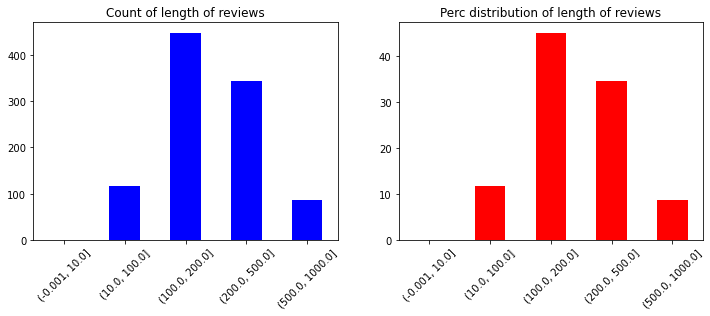

In [9]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_df["body"]]
s = pd.Series(seq_len)

out = pd.cut(s, bins=[0, 10, 100, 200, 500, 1000], include_lowest=True)
out_norm = out.value_counts(sort=False, normalize=True).mul(100)

fig,axs = plt.subplots(1,2, figsize=(12,4))
out.value_counts(sort=False).plot.bar(rot=45, color="b", ax=axs[0], title="Count of length of reviews")
out_norm.plot.bar(rot=45, color="r", ax=axs[1], title="Perc distribution of length of reviews")
plt.show()

# Step3: Modeling
### Baseline Model: Naive Bayes Classifier
In supervised machine learning, Naive Bayes are a set of algorithms based on the Bayes theorem, and assume each feature in the model is independent given the dependent variable. The conditional independence helps simplify the relationship between dependent (x) and independent (y) variables. There are various flavors of this approach based on assumption about the prior distribution P(x|y).
Inspite of strong assumptions about conditional independence, Naive Bayes algorithms show good performance on document classification, spam filtering etc. The main advantages are
* because of the simplictiy, they are extremely fast compared to other methods such as random forest, neural networks etc.
* their parameters can be estimated with small amount of training data.
* they dont suffer from curse of dimensionality, since each feature is assumed independent.

A major disadvantage is that Naive Bayes methods are not good estimators, their probability predictions are not reliable.

MultinomialNB in scikit-learn implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification. Typically, the text data is converted to numberical features as word counts, n-grams, or tf-idf representation. The parameters are estimated by a smooth version of maximum likelyhood, which is equivalent to counting relative frequency of each class.
Alpha is a smoothing parameter which accounts for features not present in the learned samples, and prevents zero probabilities in the predictions.
We use `MultinomialNB` as our baseline classifier. We create numerical features from text based on frequency count of n-grams, and use them to do the classification. The classification report based on predictions on the test set show **accuracy = 0.83**

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report


## Train model and predict
######################################################
baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), MultinomialNB())
baseline_model = baseline_model.fit(train_text, train_labels)

baseline_predicted = baseline_model.predict(test_text)
baseline_proba = baseline_model.predict_proba(test_text)
print(classification_report(test_labels, baseline_predicted))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       500
           1       0.81      0.86      0.83       500

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



### BERT Classifier
BERT (Bidirectional Encoder Representation of Transformers) is a large neural network language model (300 million parameters) based on the transformer architecture. It is pre-trained on a large corpus of unlabeled data, and is well suited for a wide-variety of classification tasks by fine-tuning an additional output layer. This process known as transfer learning provides word embeddings based on the context in its training sentences, which can be used downstream to train models for specific classification tasks. 

#### Tokenization
In this section we use the DistilBertTokenizer from transformers library for converting the text sentences into tokens based on the corpus on which BERT has been trained on. The pad_length is set at 200 based on the text length distribution analysis. The tokenizer outputs sequence of tokens and a list of attention masks. The attention vector is a list of 0 and 1, which provide reference to which words/tokens the BERT model has to pay attention. The token sequence, attention masks and the target labels are converted to pytorch tensors and saved as pickled objects for later use.

In [11]:
%%time

from preprocess import TextTokenize

# instantiate class
tokenizer = TextTokenize()

pad_length = 200 # set pad length based on sentence length distribution
save_dir = "inputs/saved_tensors"

# tokenize and encode sequences in the training set
tokenizer.token_and_encode(train_text, train_labels, pad_length, save_dir, "train")

# tokenize and encode sequences in the test set
tokenizer.token_and_encode(test_text, test_labels, pad_length, save_dir, "test")

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

CPU times: user 7.69 s, sys: 0 ns, total: 7.69 s
Wall time: 7.88 s


#### upload data to s3 for training

In [12]:
save_dir = "inputs/saved_tensors"
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/imdb_reviews_bert'


input_data = sagemaker_session.upload_data(path=save_dir, bucket=bucket, key_prefix=prefix)

#### training and evaluation using Sagemaker Estimator

In [14]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="train_eval",
                    role=role,
                    output_data_dir="{}/{}/outputs".format(bucket, prefix),
                    framework_version='1.4.0',
                    py_version='py3',
                    instance_count=1,
                    instance_type='ml.p2.xlarge',
                    debugger_hook_config=False,
                    hyperparameters={
                        'epochs': 20,
                        'batch_size':10
                    })

estimator.fit({'training': input_data})

2021-02-12 21:15:05 Starting - Starting the training job...
2021-02-12 21:15:28 Starting - Launching requested ML instancesProfilerReport-1613164504: InProgress
......
2021-02-12 21:16:28 Starting - Preparing the instances for training.........
2021-02-12 21:18:05 Downloading - Downloading input data...
2021-02-12 21:18:32 Training - Downloading the training image............
2021-02-12 21:20:34 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-02-12 21:20:27,292 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-02-12 21:20:27,317 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-02-12 21:20:27,321 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-02-12 21:20:27,638 sagemaker-containers INFO     Module default_user_module_name does not prov

Done loading model.
Get train and test data loader.
#033[2K#015#033[2K#015Epoch:1, steps: 0/100.0, loss: 0.7017285227775574 #015#033[2K#015#033[2K#015Epoch:1, steps: 1/100.0, loss: 0.6922083497047424 #015#033[2K#015#033[2K#015Epoch:1, steps: 2/100.0, loss: 0.6962758501370748 #015#033[2K#015#033[2K#015Epoch:1, steps: 3/100.0, loss: 0.6943808495998383 #015#033[2K#015#033[2K#015Epoch:1, steps: 4/100.0, loss: 0.6866797924041748 #015#033[2K#015#033[2K#015Epoch:1, steps: 5/100.0, loss: 0.6881068448225657 #015#033[2K#015#033[2K#015Epoch:1, steps: 6/100.0, loss: 0.6814686826297215 #015#033[2K#015#033[2K#015Epoch:1, steps: 7/100.0, loss: 0.6830698996782303 #015#033[2K#015#033[2K#015Epoch:1, steps: 8/100.0, loss: 0.683562245633867 #015#033[2K#015#033[2K#015Epoch:1, steps: 9/100.0, loss: 0.6799054622650147 #015#033[2K#015#033[2K#015Epoch:1, steps: 10/100.0, loss: 0.6809576912359758 #015#033[2K#015#033[2K#015Epoch:1, steps: 11/100.0, loss: 0.6777429779370626 #015#033[2K#015#033[2K#015Epoch:1, step

4160708360947095 #015#033[2K#015#033[2K#015Epoch:3, steps: 65/100.0, loss: 0.4128910808852225 #015#033[2K#015#033[2K#015Epoch:3, steps: 66/100.0, loss: 0.4108601114643154 #015#033[2K#015#033[2K#015Epoch:3, steps: 67/100.0, loss: 0.4088785779826781 #015#033[2K#015#033[2K#015Epoch:3, steps: 68/100.0, loss: 0.40628475512283435 #015#033[2K#015#033[2K#015Epoch:3, steps: 69/100.0, loss: 0.4048145596470152 #015#033[2K#015#033[2K#015Epoch:3, steps: 70/100.0, loss: 0.40438242613429753 #015#033[2K#015#033[2K#015Epoch:3, steps: 71/100.0, loss: 0.40535511780116296 #015#033[2K#015#033[2K#015Epoch:3, steps: 72/100.0, loss: 0.4075211021181655 #015#033[2K#015#033[2K#015Epoch:3, steps: 73/100.0, loss: 0.4065239602649534 #015#033[2K#015#033[2K#015Epoch:3, steps: 74/100.0, loss: 0.4068500034014384 #015#033[2K#015#033[2K#015Epoch:3, steps: 75/100.0, loss: 0.40854734103930623 #015#033[2K#015#033[2K#015Epoch:3, steps: 76/100.0, loss: 0.4082143898908194 #015#033[2K#015#033[2K#015Epoch:3, steps: 77/100.0, los

h:6, steps: 27/100.0, loss: 0.16788464146000998 #015#033[2K#015#033[2K#015Epoch:6, steps: 28/100.0, loss: 0.1660466186445335 #015#033[2K#015#033[2K#015Epoch:6, steps: 29/100.0, loss: 0.16689567789435386 #015#033[2K#015#033[2K#015Epoch:6, steps: 30/100.0, loss: 0.17255843286552736 #015#033[2K#015#033[2K#015Epoch:6, steps: 31/100.0, loss: 0.1780349335167557 #015#033[2K#015#033[2K#015Epoch:6, steps: 32/100.0, loss: 0.1752136160026897 #015#033[2K#015#033[2K#015Epoch:6, steps: 33/100.0, loss: 0.17517586446860256 #015#033[2K#015#033[2K#015Epoch:6, steps: 34/100.0, loss: 0.17810446662562235 #015#033[2K#015#033[2K#015Epoch:6, steps: 35/100.0, loss: 0.17484981959892643 #015#033[2K#015#033[2K#015Epoch:6, steps: 36/100.0, loss: 0.18607902184531494 #015#033[2K#015#033[2K#015Epoch:6, steps: 37/100.0, loss: 0.1826497468313104 #015#033[2K#015#033[2K#015Epoch:6, steps: 38/100.0, loss: 0.18197865889240533 #015#033[2K#015#033[2K#015Epoch:6, steps: 39/100.0, loss: 0.17939138105139135 #015#033[2K#015#033[

759164498344565 #015#033[2K#015#033[2K#015Epoch:8, steps: 89/100.0, loss: 0.08682559654116631 #015#033[2K#015#033[2K#015Epoch:8, steps: 90/100.0, loss: 0.0861195291259459 #015#033[2K#015#033[2K#015Epoch:8, steps: 91/100.0, loss: 0.08543326523478913 #015#033[2K#015#033[2K#015Epoch:8, steps: 92/100.0, loss: 0.08910377800304403 #015#033[2K#015#033[2K#015Epoch:8, steps: 93/100.0, loss: 0.09189073689916033 #015#033[2K#015#033[2K#015Epoch:8, steps: 94/100.0, loss: 0.09342439233472473 #015#033[2K#015#033[2K#015Epoch:8, steps: 95/100.0, loss: 0.09301078917148213 #015#033[2K#015#033[2K#015Epoch:8, steps: 96/100.0, loss: 0.09222848321666423 #015#033[2K#015#033[2K#015Epoch:8, steps: 97/100.0, loss: 0.09624289181463573 #015#033[2K#015#033[2K#015Epoch:8, steps: 98/100.0, loss: 0.09544047314410257 #015#033[2K#015#033[2K#015Epoch:8, steps: 99/100.0, loss: 0.09605977140367031 #015#033[2K#015#033[2K#015Epoch:9, steps: 0/100.0, loss: 0.0256918016821146 #015#033[2K#015#033[2K#015Epoch:9, steps: 1/100.0, 

100.0, loss: 0.04774793945847357 #015#033[2K#015#033[2K#015Epoch:11, steps: 47/100.0, loss: 0.0468783680019745 #015#033[2K#015#033[2K#015Epoch:11, steps: 48/100.0, loss: 0.046034013510358573 #015#033[2K#015#033[2K#015Epoch:11, steps: 49/100.0, loss: 0.04523443445563316 #015#033[2K#015#033[2K#015Epoch:11, steps: 50/100.0, loss: 0.04451543481691795 #015#033[2K#015#033[2K#015Epoch:11, steps: 51/100.0, loss: 0.043766200981246166 #015#033[2K#015#033[2K#015Epoch:11, steps: 52/100.0, loss: 0.043042445247817154 #015#033[2K#015#033[2K#015Epoch:11, steps: 53/100.0, loss: 0.04236216685320768 #015#033[2K#015#033[2K#015Epoch:11, steps: 54/100.0, loss: 0.04171369118954648 #015#033[2K#015#033[2K#015Epoch:11, steps: 55/100.0, loss: 0.04106991276577381 #015#033[2K#015#033[2K#015Epoch:11, steps: 56/100.0, loss: 0.04090231811431678 #015#033[2K#015#033[2K#015Epoch:11, steps: 57/100.0, loss: 0.040297917499817135 #015#033[2K#015#033[2K#015Epoch:11, steps: 58/100.0, loss: 0.04839508537739768 #015#033[2K#015#

10398954153 #015#033[2K#015#033[2K#015Epoch:14, steps: 1/100.0, loss: 0.003031574306078255 #015#033[2K#015#033[2K#015Epoch:14, steps: 2/100.0, loss: 0.003125539127116402 #015#033[2K#015#033[2K#015Epoch:14, steps: 3/100.0, loss: 0.12265630118781701 #015#033[2K#015#033[2K#015Epoch:14, steps: 4/100.0, loss: 0.09936515050940216 #015#033[2K#015#033[2K#015Epoch:14, steps: 5/100.0, loss: 0.08336507567825417 #015#033[2K#015#033[2K#015Epoch:14, steps: 6/100.0, loss: 0.07195482073750879 #015#033[2K#015#033[2K#015Epoch:14, steps: 7/100.0, loss: 0.06341406248975545 #015#033[2K#015#033[2K#015Epoch:14, steps: 8/100.0, loss: 0.05674224688361088 #015#033[2K#015#033[2K#015Epoch:14, steps: 9/100.0, loss: 0.051414788840338586 #015#033[2K#015#033[2K#015Epoch:14, steps: 10/100.0, loss: 0.047018584816462615 #015#033[2K#015#033[2K#015Epoch:14, steps: 11/100.0, loss: 0.043372223347735904 #015#033[2K#015#033[2K#015Epoch:14, steps: 12/100.0, loss: 0.04028896466255761 #015#033[2K#015#033[2K#015Epoch:14, steps: 1

/100.0, loss: 0.010310203304768286 #015#033[2K#015#033[2K#015Epoch:16, steps: 55/100.0, loss: 0.01016657468738101 #015#033[2K#015#033[2K#015Epoch:16, steps: 56/100.0, loss: 0.010020962612000866 #015#033[2K#015#033[2K#015Epoch:16, steps: 57/100.0, loss: 0.009879826208785305 #015#033[2K#015#033[2K#015Epoch:16, steps: 58/100.0, loss: 0.00974021436078316 #015#033[2K#015#033[2K#015Epoch:16, steps: 59/100.0, loss: 0.009608526970259846 #015#033[2K#015#033[2K#015Epoch:16, steps: 60/100.0, loss: 0.009481729498728499 #015#033[2K#015#033[2K#015Epoch:16, steps: 61/100.0, loss: 0.009358936582782095 #015#033[2K#015#033[2K#015Epoch:16, steps: 62/100.0, loss: 0.009433541158657698 #015#033[2K#015#033[2K#015Epoch:16, steps: 63/100.0, loss: 0.009314862934843404 #015#033[2K#015#033[2K#015Epoch:16, steps: 64/100.0, loss: 0.00919518808189493 #015#033[2K#015#033[2K#015Epoch:16, steps: 65/100.0, loss: 0.009103164376662762 #015#033[2K#015#033[2K#015Epoch:16, steps: 66/100.0, loss: 0.008995440722540465 #015#033

 0.02583154194871895 #015#033[2K#015#033[2K#015Epoch:19, steps: 8/100.0, loss: 0.02310524102196925 #015#033[2K#015#033[2K#015Epoch:19, steps: 9/100.0, loss: 0.020917517761699856 #015#033[2K#015#033[2K#015Epoch:19, steps: 10/100.0, loss: 0.019114539566957814 #015#033[2K#015#033[2K#015Epoch:19, steps: 11/100.0, loss: 0.01763263169171599 #015#033[2K#015#033[2K#015Epoch:19, steps: 12/100.0, loss: 0.01635368248053755 #015#033[2K#015#033[2K#015Epoch:19, steps: 13/100.0, loss: 0.015268164786643215 #015#033[2K#015#033[2K#015Epoch:19, steps: 14/100.0, loss: 0.014335504624371727 #015#033[2K#015#033[2K#015Epoch:19, steps: 15/100.0, loss: 0.013506150353350677 #015#033[2K#015#033[2K#015Epoch:19, steps: 16/100.0, loss: 0.01280096295180128 #015#033[2K#015#033[2K#015Epoch:19, steps: 17/100.0, loss: 0.012155790399346087 #015#033[2K#015#033[2K#015Epoch:19, steps: 18/100.0, loss: 0.011657787719741464 #015#033[2K#015#033[2K#015Epoch:19, steps: 19/100.0, loss: 0.011160961032146588 #015#033[2K#015#033[2K#01

2021-02-12 21:49:28,630 sagemaker-containers INFO     Reporting training SUCCESS
0/100.0 loss: 2.256279706954956 #0151/100.0 loss: 1.7947095036506653 #0152/100.0 loss: 1.1967790595954284 #0153/100.0 loss: 0.9361483434040565 #0154/100.0 loss: 0.7490713648963719 #0155/100.0 loss: 0.8692794684708739 #0156/100.0 loss: 0.8534683622752449 #0157/100.0 loss: 0.7665635883167852 #0158/100.0 loss: 0.7634927775555601 #0159/100.0 loss: 0.8859004806960001 #01510/100.0 loss: 0.8094678700859235 #01511/100.0 loss: 0.793196088653834 #01512/100.0 loss: 0.8381579074328049 #01513/100.0 loss: 0.8221717575465196 #01514/100.0 loss: 0.8196947388506184 #01515/100.0 loss: 0.805288539515459 #01516/100.0 loss: 0.7931196244899184 #01517/100.0 loss: 0.8314110945211723 #01518/100.0 loss: 0.8080193018173113 #01519/100.0 loss: 0.7862264225375839 #01520/100.0 loss: 0.8179450327907467 #01521/100.0 loss: 0.8133481559872796 #01522/100.0 loss: 0.7892864264001179 #01523/100.0 loss: 0.8158610806276556 #01524/100.0 loss: 0.811

#### download model outputs from S3 for analysis

In [15]:
import boto3
import botocore
import os
import shutil
import pickle

os.makedirs("outputs",exist_ok=True)

# download model artifacts from s3
s3_path = estimator.model_data
key = s3_path.replace("s3://{}/".format(bucket), "")

s3 = boto3.resource('s3')
s3.Bucket(bucket).download_file(KEY, 'outputs/model_data.tar.gz')

        
# unpack the compressed file
shutil.unpack_archive("outputs/model_data.tar.gz", extract_dir="outputs")

# read the pickled outputs from model run
with open("outputs/train_losses.pt","rb") as f:
    train_steps, train_losses = pickle.load(f)
    
with open("outputs/test_losses.pt", "rb") as f:
    test_steps, test_loss, y_prob, y_pred, test_y = pickle.load(f)

### Training and Test loss vs iteration

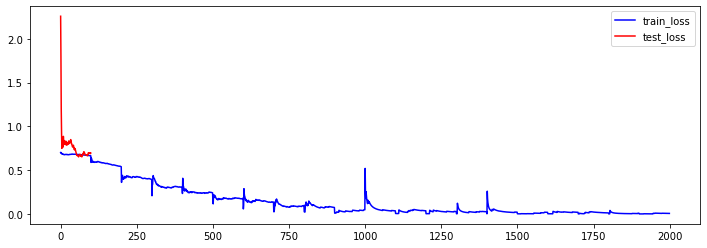

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize=(12,4))

ax.plot(train_steps, train_losses, color="b", label = "train_loss")
ax.plot(test_steps, test_loss, color="r", label = "test_loss")
ax.legend()
plt.show()

#### Classification Report for the BERT model
The accuracy is 0.88 as compared to 0.83 for the baseline model

In [17]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88       500
           1       0.88      0.87      0.87       500

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



### ROC curve for BERT and the naive Bayes classifier

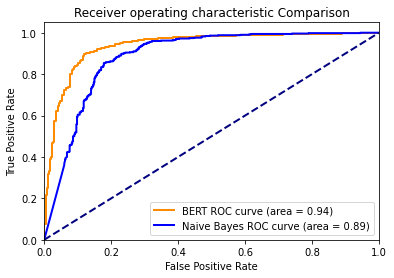

In [28]:
from sklearn.metrics import roc_curve, auc

bert_fpr, bert_tpr, _ = roc_curve(test_y, y_prob)
bert_auc = auc(fpr, tpr)
nb_fpr, nb_tpr, _ = roc_curve(test_labels, baseline_proba[:,1])
nb_auc = auc(nb_fpr, nb_tpr)

plt.figure()
lw = 2
plt.plot(bert_fpr, bert_tpr, color='darkorange',
         lw=lw, label='BERT ROC curve (area = %0.2f)' % bert_auc)
plt.plot(nb_fpr, nb_tpr, color='blue',
         lw=lw, label='Naive Bayes ROC curve (area = %0.2f)' % nb_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Comparison')
plt.legend(loc="lower right")
plt.show()